# Orlando - Regressão Multiparametros - Games

https://www.kaggle.com/datasets/gregorut/videogamesales

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 América do Norte
   → MAE : 0.2601
   → MSE : 0.6610
   → R²  : 0.1452

📊 Europa
   → MAE : 0.1780
   → MSE : 0.2783
   → R²  : 0.1908

📊 Japão
   → MAE : 0.0532
   → MSE : 0.0588
   → R²  : -0.1110


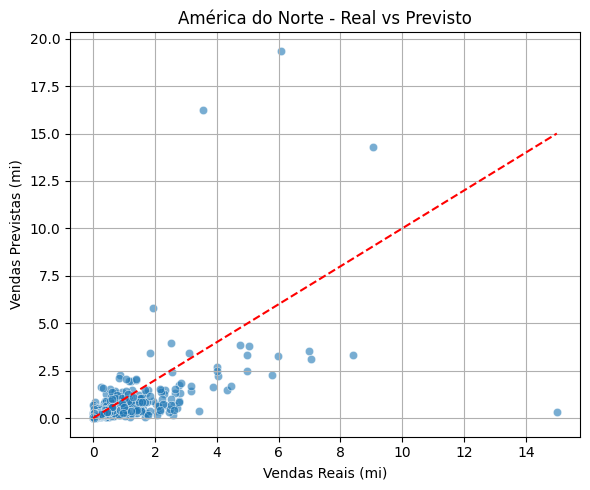

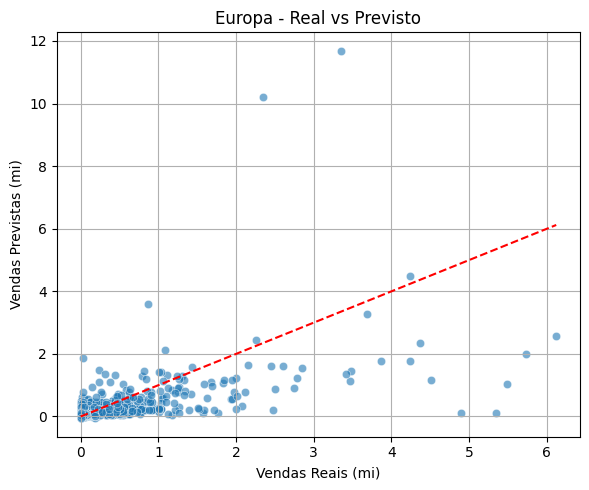

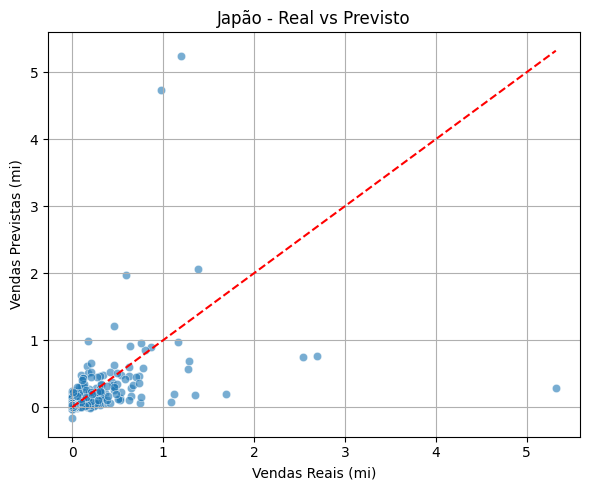

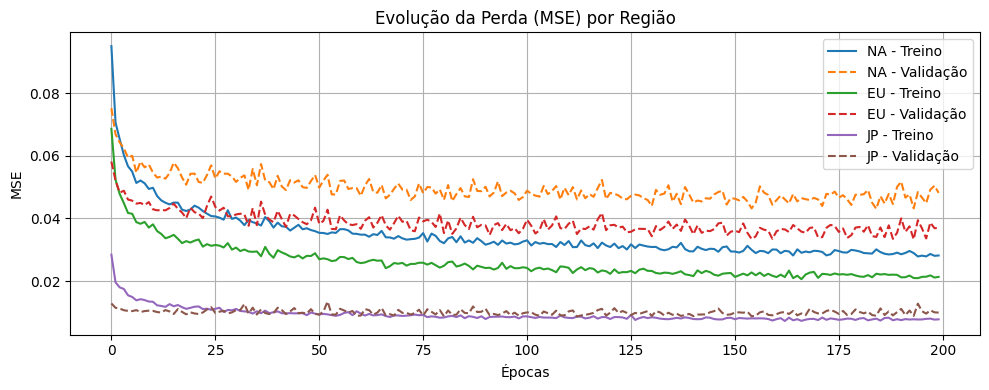

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

# ---------------------------------------
# 1. Carregamento e limpeza
# ---------------------------------------
base = pd.read_csv("games.csv")
base.drop(columns=["Other_Sales", "Global_Sales", "Developer", "Name"], inplace=True)
base.dropna(inplace=True)

# ---------------------------------------
# 2. Separação de X e y
# ---------------------------------------
X = base.iloc[:, [0, 1, 2, 3, 7, 8, 9, 10, 11]].values
y_na = np.log1p(base.iloc[:, 4].values)
y_eu = np.log1p(base.iloc[:, 5].values)
y_jp = np.log1p(base.iloc[:, 6].values)

# ---------------------------------------
# 3. OneHot + Normalização
# ---------------------------------------
column_transformer = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(sparse_output=False), [0, 2, 3, 8])
], remainder="passthrough")

X = column_transformer.fit_transform(X)
X = MinMaxScaler().fit_transform(X)

# ---------------------------------------
# 4. Separação treino/teste unificada
# ---------------------------------------
Y = np.stack([y_na, y_eu, y_jp], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

y_na_train, y_eu_train, y_jp_train = Y_train[:, 0], Y_train[:, 1], Y_train[:, 2]
y_na_test, y_eu_test, y_jp_test = Y_test[:, 0], Y_test[:, 1], Y_test[:, 2]

# ---------------------------------------
# 5. Arquitetura do modelo
# ---------------------------------------
input_dim = X.shape[1]
entrada = Input(shape=(input_dim,))

x = Dense(256)(entrada)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)

x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

x = Dense(64)(x)
x = LeakyReLU()(x)

saida_na = Dense(1, activation="linear", name="NA")(x)
saida_eu = Dense(1, activation="linear", name="EU")(x)
saida_jp = Dense(1, activation="linear", name="JP")(x)

model = Model(inputs=entrada, outputs={"NA": saida_na, "EU": saida_eu, "JP": saida_jp})

# ---------------------------------------
# 6. Compilação
# ---------------------------------------
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={"NA": "mse", "EU": "mse", "JP": "mse"}
)

# ---------------------------------------
# 7. Treinamento
# ---------------------------------------
history = model.fit(
    X_train,
    {"NA": y_na_train, "EU": y_eu_train, "JP": y_jp_train},
    validation_data=(X_test, {"NA": y_na_test, "EU": y_eu_test, "JP": y_jp_test}),
    epochs=200,
    batch_size=100,
    verbose=0
)

# ---------------------------------------
# 8. Avaliação
# ---------------------------------------
previsao = model.predict(X_test)
previsao_na, previsao_eu, previsao_jp = previsao["NA"], previsao["EU"], previsao["JP"]

def avaliar(y_true, y_pred, nome):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {nome}")
    print(f"   → MAE : {mae:.4f}")
    print(f"   → MSE : {mse:.4f}")
    print(f"   → R²  : {r2:.4f}")

avaliar(y_na_test, previsao_na, "América do Norte")
avaliar(y_eu_test, previsao_eu, "Europa")
avaliar(y_jp_test, previsao_jp, "Japão")

# ---------------------------------------
# 9. Gráficos
# ---------------------------------------
def grafico_disp(y_real, y_pred, regiao):
    y_real = np.expm1(y_real).ravel()
    y_pred = np.expm1(y_pred).ravel()
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_real, y=y_pred, alpha=0.6)
    plt.plot([0, max(y_real)], [0, max(y_real)], "--", color="red")
    plt.xlabel("Vendas Reais (mi)")
    plt.ylabel("Vendas Previstas (mi)")
    plt.title(f"{regiao} - Real vs Previsto")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

grafico_disp(y_na_test, previsao_na, "América do Norte")
grafico_disp(y_eu_test, previsao_eu, "Europa")
grafico_disp(y_jp_test, previsao_jp, "Japão")

# ---------------------------------------
# 10. Curva de perda
# ---------------------------------------
plt.figure(figsize=(10, 4))
for name in ["NA", "EU", "JP"]:
    plt.plot(history.history[f"{name}_loss"], label=f"{name} - Treino")
    plt.plot(history.history[f"val_{name}_loss"], "--", label=f"{name} - Validação")

plt.title("Evolução da Perda (MSE) por Região")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### versão antes de piorar:

214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
📊 América do Norte:
   → MAE : 0.2968
   → MSE : 0.6724
   → R²  : 0.2813

📊 Europa:
   → MAE : 0.1921
   → MSE : 0.3422
   → R²  : 0.2756

📊 Japão:
   → MAE : 0.0932
   → MSE : 0.0706
   → R²  : 0.1465



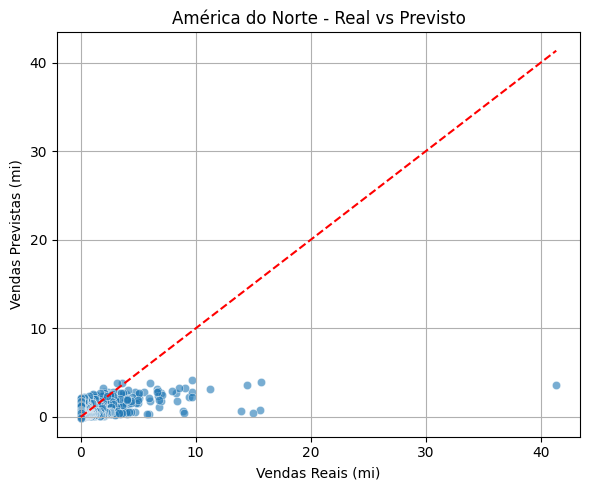

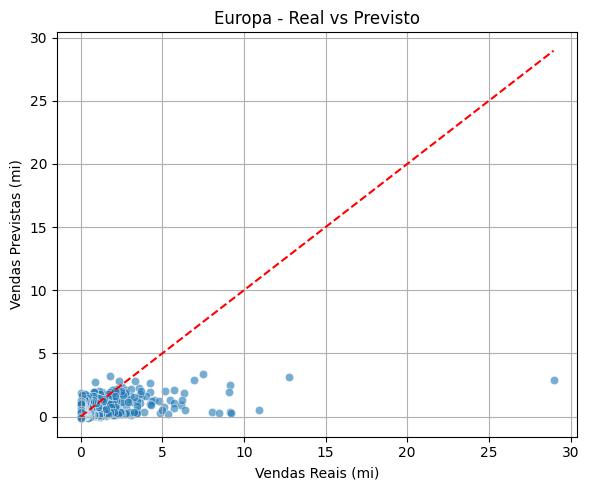

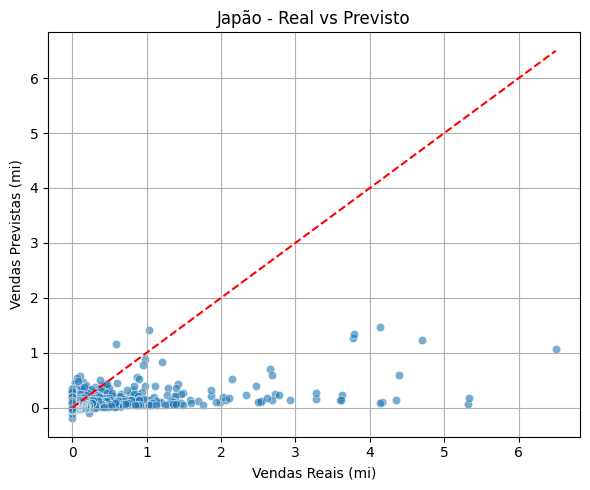

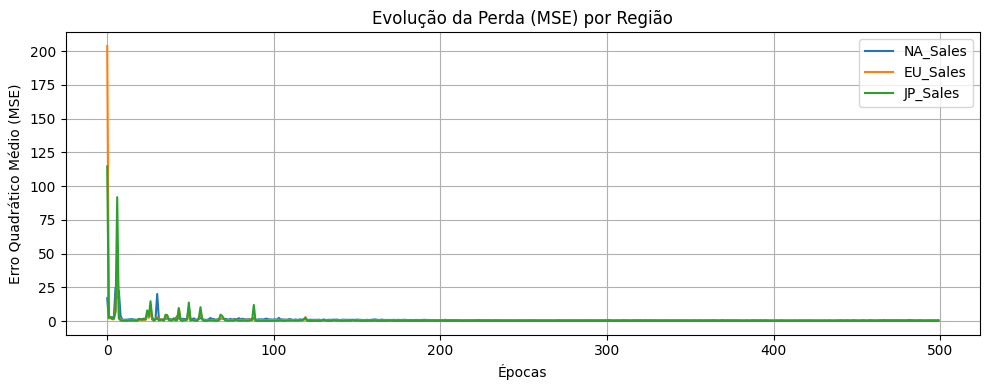

In [16]:
# ---------------------------------------
# 1. Bibliotecas
# ---------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# ---------------------------------------
# 2. Carregamento e limpeza dos dados
# ---------------------------------------
base = pd.read_csv('games.csv')

# Remoção de colunas irrelevantes para o modelo
base.drop(columns=['Other_Sales', 'Global_Sales', 'Developer', 'Name'], inplace=True)

# Eliminação de linhas com valores ausentes
base.dropna(inplace=True)

# ---------------------------------------
# 3. Separação entre variáveis preditoras e saídas
# ---------------------------------------
# Colunas categóricas e numéricas selecionadas para X
X = base.iloc[:, [0, 1, 2, 3, 7, 8, 9, 10, 11]].values

# Targets: vendas por região
y_na = base.iloc[:, 4].values  # North America
y_eu = base.iloc[:, 5].values  # Europe
y_jp = base.iloc[:, 6].values  # Japan

# ---------------------------------------
# 4. Codificação OneHot das variáveis categóricas
# ---------------------------------------
onehotencoder = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(sparse_output=False), [0, 2, 3, 8])
], remainder='passthrough')

X = onehotencoder.fit_transform(X)

# Conversão para tipo numérico adequado
X = np.array(X).astype(np.float32)
y_na = np.array(y_na).astype(np.float32)
y_eu = np.array(y_eu).astype(np.float32)
y_jp = np.array(y_jp).astype(np.float32)

# ---------------------------------------
# 5. Arquitetura da Rede Neural com múltiplas saídas
# ---------------------------------------
input_dim = X.shape[1]
hidden_units = int((input_dim + 3) / 2)

entrada = Input(shape=(input_dim,))
oculta1 = Dense(units=hidden_units, activation='relu')(entrada)
oculta2 = Dense(units=hidden_units, activation='relu')(oculta1)

# Saídas separadas para cada região
saida_na = Dense(units=1, activation='linear', name='NA_Sales')(oculta2)
saida_eu = Dense(units=1, activation='linear', name='EU_Sales')(oculta2)
saida_jp = Dense(units=1, activation='linear', name='JP_Sales')(oculta2)

regressor = Model(inputs=entrada, outputs=[saida_na, saida_eu, saida_jp])

# ---------------------------------------
# 6. Compilação e treinamento
# ---------------------------------------
regressor.compile(optimizer='adam', loss='mse')

history = regressor.fit(
    X,
    [y_na, y_eu, y_jp],
    epochs=500,
    batch_size=100,
    verbose=0  # Troque para 1 se quiser ver as barras de progresso
)

# ---------------------------------------
# 7. Avaliação com métricas
# ---------------------------------------
previsao_na, previsao_eu, previsao_jp = regressor.predict(X)

def avaliar(y_true, y_pred, nome):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {nome}:")
    print(f"   → MAE : {mae:.4f}")
    print(f"   → MSE : {mse:.4f}")
    print(f"   → R²  : {r2:.4f}\n")

avaliar(y_na, previsao_na, "América do Norte")
avaliar(y_eu, previsao_eu, "Europa")
avaliar(y_jp, previsao_jp, "Japão")

# ---------------------------------------
# 8. Visualizações
# ---------------------------------------

# Função para gráfico de dispersão real vs previsto
def grafico_disp(y_real, y_pred, regiao):
    y_real = y_real.ravel()
    y_pred = y_pred.ravel()
    
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_real, y=y_pred, alpha=0.6)
    plt.plot([0, max(y_real)], [0, max(y_real)], '--', color='red')
    plt.xlabel('Vendas Reais (mi)')
    plt.ylabel('Vendas Previstas (mi)')
    plt.title(f'{regiao} - Real vs Previsto')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

grafico_disp(y_na, previsao_na, 'América do Norte')
grafico_disp(y_eu, previsao_eu, 'Europa')
grafico_disp(y_jp, previsao_jp, 'Japão')

# Curvas de perda (loss) por saída
plt.figure(figsize=(10, 4))
for i, name in enumerate(['NA_Sales', 'EU_Sales', 'JP_Sales']):
    plt.plot(history.history[f'{name}_loss'], label=name)
plt.title("Evolução da Perda (MSE) por Região")
plt.xlabel("Épocas")
plt.ylabel("Erro Quadrático Médio (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Considerações:

Aplicar transformação logarítmica nas saídas (log1p/expm1)

Testar regularização (Dropout ou L2)

Avaliar com validação cruzada

Comparar com modelos de regressão tradicionais (Random Forest, Ridge)